# Rede Neural (análise de sentimento de imagens da página do Facebook)

In [527]:
!python -m pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [528]:
!python -m pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [529]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
from google.colab import drive

In [530]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [531]:
pasta_imagens_treino = Path('/content/drive/My Drive/TechChallenge5/treino')
# filepaths = list(pasta_imagens.glob(r'**/*.png')) + list(pasta_imagens.glob(r'**/*.jpeg')) + list(pasta_imagens.glob(r'**/*.jpg'))
filepaths_treino = list(pasta_imagens_treino.glob(r'**/*.*'))
filepaths_treino

[PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/1.png'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/4.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/5.jpeg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/6.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/7.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/8.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/9.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/2.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/3.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/10.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/11.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/12.jpeg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/treino/feliz/13.jpg'),
 PosixPath('/content/drive/My Drive/TechChall

In [532]:
pasta_imagens_validacao = Path('/content/drive/My Drive/TechChallenge5/validacao')
# filepaths = list(pasta_imagens.glob(r'**/*.png')) + list(pasta_imagens.glob(r'**/*.jpeg')) + list(pasta_imagens.glob(r'**/*.jpg'))
filepaths_validacao = list(pasta_imagens_validacao.glob(r'**/*.*'))
filepaths_validacao

[PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/1.png'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/2.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/3.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/4.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/5.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/7.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/6.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/8.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/9.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/10.jpeg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/14.jpeg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/12.jpeg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/validacao/feliz/11.jpeg'),
 Pos

In [533]:
pasta_imagens_teste = Path('/content/drive/My Drive/TechChallenge5/teste')
# filepaths = list(pasta_imagens.glob(r'**/*.png')) + list(pasta_imagens.glob(r'**/*.jpeg')) + list(pasta_imagens.glob(r'**/*.jpg'))
filepaths_teste = list(pasta_imagens_teste.glob(r'**/*.*'))
filepaths_teste

[PosixPath('/content/drive/My Drive/TechChallenge5/teste/neutro/2.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/neutro/4.png'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/neutro/8.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/feliz/1.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/feliz/3.png'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/feliz/5.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/feliz/6.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/feliz/7.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/feliz/9.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/feliz/10.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/bravo/1.jpg'),
 PosixPath('/content/drive/My Drive/TechChallenge5/teste/triste/1.jpg')]

In [534]:
# preparando o generator para a base de treinamento
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# preparando o generator para a base de validação
val_datagen = ImageDataGenerator(rescale=1.0/255)

# criando a base de treinamento
train_generator = train_datagen.flow_from_directory(
    pasta_imagens_treino,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# criando a base de validação
validation_generator = val_datagen.flow_from_directory(
    pasta_imagens_validacao,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# criando a base de teste
test_generator = val_datagen.flow_from_directory(
    pasta_imagens_teste,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 127 images belonging to 4 classes.
Found 59 images belonging to 4 classes.
Found 12 images belonging to 4 classes.


In [556]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'bravo': 0, 'feliz': 1, 'neutro': 2, 'triste': 3}
{'bravo': 0, 'feliz': 1, 'neutro': 2, 'triste': 3}
{'bravo': 0, 'feliz': 1, 'neutro': 2, 'triste': 3}


In [535]:
# utilizamos o MobileNetV2, uma rede já treinada previamente como base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax') # 4 categorias finais
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [536]:
callbacks = [
    EarlyStopping(patience=30, restore_best_weights=True),
    ModelCheckpoint('best_mobilenetv2_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 1.5255 - accuracy: 0.2756

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 27s 5s/step - loss: 1.5255 - accuracy: 0.2756 - val_loss: 1.6481 - val_accuracy: 0.3220
Epoch 2/50
4/4 [==============================] - 10s 2s/step - loss: 1.1987 - accuracy: 0.4961 - val_loss: 1.6388 - val_accuracy: 0.3390
Epoch 3/50
4/4 [==============================] - 11s 3s/step - loss: 1.0118 - accuracy: 0.6142 - val_loss: 1.5104 - val_accuracy: 0.3220
Epoch 4/50
4/4 [==============================] - 11s 3s/step - loss: 0.9289 - accuracy: 0.6614 - val_loss: 1.4177 - val_accuracy: 0.3898
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 0.8051 - accuracy: 0.7559 - val_loss: 1.4438 - val_accuracy: 0.4237
Epoch 6/50
4/4 [==============================] - 11s 3s/step - loss: 0.7262 - accuracy: 0.7087 - val_loss: 1.4775 - val_accuracy: 0.4407
Epoch 7/50
4/4 [==============================] - 11s 3s/step - loss: 0.6383 - accuracy: 0.8031 - val_loss: 1.4595 - val_accuracy: 0.4407
Epoch 8/50
4/4 [==============================

In [537]:
loss, accuracy = model.evaluate(test_generator)
print(f'Acurácia: {accuracy * 100:.2f}%')

1/1 [==============================] - 1s 588ms/step - loss: 0.7937 - accuracy: 0.8333
Acurácia: 83.33%


In [557]:
# previsão do sentimento
def cnn_predict(filepath):
    image = cv2.imread(filepath)
    img = cv2.resize(image, (224, 224)).astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    classe_idx = np.argmax(pred, axis=1)[0]
    #'bravo': 0, 'feliz': 1, 'neutro': 2, 'triste': 3
    classes_labels = ['bravo', 'feliz', 'neutro', 'triste']

    print(pred)
    print(classe_idx)
    print(classes_labels[classe_idx])

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

1/1 [==============================] - 0s 57ms/step
[[0.18595739 0.487096   0.17658024 0.1503664 ]]
1
feliz


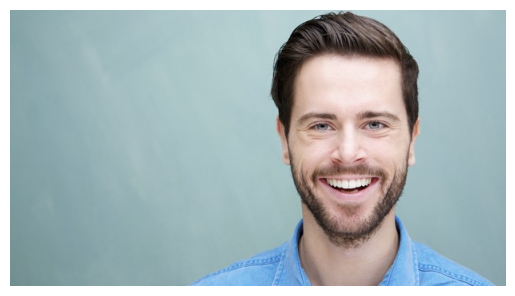

In [558]:
cnn_predict('/content/drive/My Drive/TechChallenge5/teste/feliz/1.jpg')

1/1 [==============================] - 0s 56ms/step
[[0.09213454 0.41236696 0.1992814  0.29621714]]
1
feliz


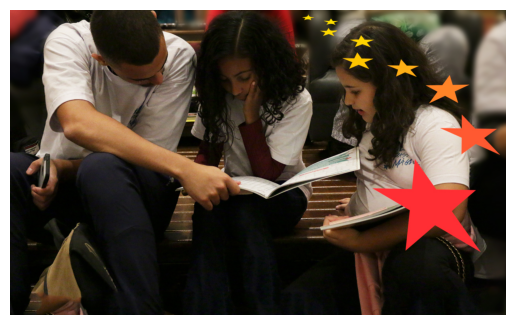

In [559]:
cnn_predict('/content/drive/My Drive/TechChallenge5/teste/neutro/2.jpg')

1/1 [==============================] - 0s 49ms/step
[[0.18973446 0.5108311  0.07773697 0.22169742]]
1
feliz


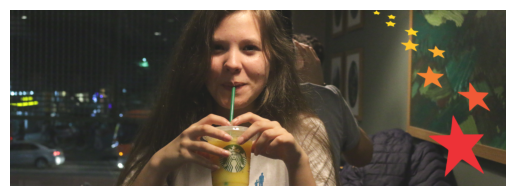

In [560]:
cnn_predict('/content/drive/My Drive/TechChallenge5/teste/feliz/3.png')

1/1 [==============================] - 0s 51ms/step
[[0.15798052 0.51997846 0.16631512 0.15572593]]
1
feliz


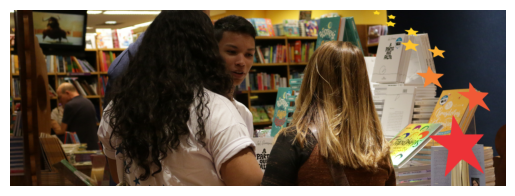

In [561]:
cnn_predict('/content/drive/My Drive/TechChallenge5/teste/neutro/4.png')

## Exportando o modelo para uso no Streamlit

In [562]:
model.save('cnn')

## Importando o modelo para teste

In [563]:
model = load_model('cnn')

1/1 [==============================] - 1s 1s/step
[[0.10325696 0.5562994  0.23650983 0.10393378]]
1
feliz


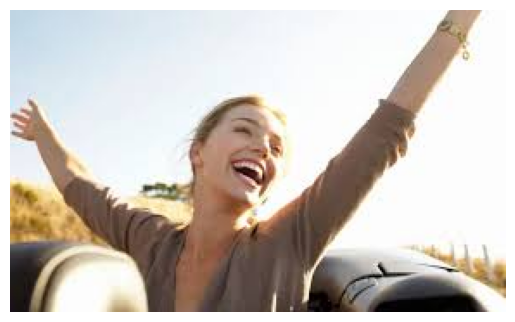

In [564]:
cnn_predict('/content/drive/My Drive/TechChallenge5/teste/feliz/9.jpg')

1/1 [==============================] - 0s 54ms/step
[[0.27567512 0.33764732 0.1575955  0.22908211]]
1
feliz


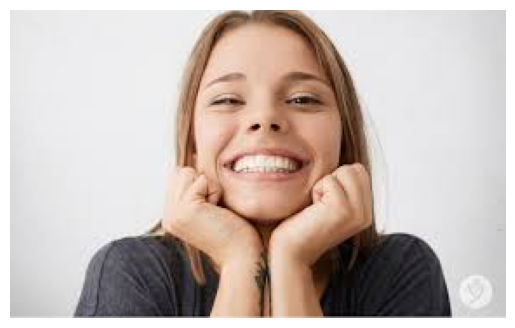

In [565]:
cnn_predict('/content/drive/My Drive/TechChallenge5/teste/feliz/10.jpg')